In [56]:
%env CUDA_VISIBLE_DEVICES=1,2

env: CUDA_VISIBLE_DEVICES=1,2


#### Imports

In [57]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm 
from torch.utils.data import Dataset
import torch

#### Utils

In [5]:
import json

with open('config.json', 'r') as f:
    config = json.load(f)

DATASET_PATH = config['DATASET_PATH']['all']
MAC_DATASET_PATH = config['DATASET_PATH']['mac']
LENOVO_DATASET_PATH = config['DATASET_PATH']['lenovo']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Create Dataset fot Training

### 1.1 Audio Keystroke Dataset

In [ ]:
def extract_label_and_device(filepath, full_dataset=False):
    filepath = filepath.replace("\\", "/")
    parts = filepath.split("/")

    if "ProcessedWithImage" in parts:
        label = parts[-3].lower()
        combined = parts[-2].lower()
        if combined.startswith(label):
            device = combined[len(label):]
        else:
            device = "unknown"
        # Debug print
    elif full_dataset:
        label = os.path.basename(os.path.dirname(filepath)).lower()
        filename = os.path.splitext(os.path.basename(filepath))[0].lower()
        if filename.startswith(label):
            device = filename[len(label):] 
        else:
            device = "unknown"
    else:
        parts = filepath.split("/")
        device = parts[-3].lower()
        label = os.path.splitext(os.path.basename(filepath))[0].lower()

    return label, device

def visualize_keystrokes(audio, sr, segment_starts, title="Detected Keystrokes"):
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(audio, sr=sr)
    for start_time in segment_starts:
        plt.axvline(start_time, color='red', linestyle='--')
    plt.title(title)
    plt.show()
    
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio))
    augmented = audio + noise_level * noise
    return augmented.astype(np.float32)

def random_gain(audio, min_gain=0.8, max_gain=1.2):
    gain = np.random.uniform(min_gain, max_gain)
    return audio * gain

def pitch_shift(audio, sr, n_steps=1):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def time_shift(segment, max_shift_percentage=0.4):
    # Calculate the maximum shift in samples
    max_shift = int(len(segment) * max_shift_percentage)
    # Take a random integer shift within the range [-max_shift, max_shift]
    shift = np.random.randint(-max_shift, max_shift)
    # Shift the segment
    shifted_segment = np.roll(segment, shift)
    # Zero out the wrapped portion to avoid artifacts
    if shift > 0:
        shifted_segment[:shift] = 0
    elif shift < 0:
        shifted_segment[shift:] = 0
    return shifted_segment

def generate_mel_spectrogram(segment, sr, n_mels=64, n_fft=1024, hop_length=225):
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft,  hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

def spec_augment(spectrogram, time_mask_percentage=0.1, freq_mask_percentage=0.1):
    augmented_spec = spectrogram.copy()
    n_mels, n_time = augmented_spec.shape
    # Calculate mask lengths
    time_mask_length = max(1, int(n_time * time_mask_percentage))
    freq_mask_length = max(1, int(n_mels * freq_mask_percentage))
    # Mask Value (mean of spectrogram)
    mask_value = np.mean(augmented_spec)
    # Apply Time Mask: Select a random start point and mask time steps across all frequencies
    time_start = np.random.randint(0, n_time - time_mask_length + 1)
    augmented_spec[:, time_start:time_start + time_mask_length] = mask_value
    # Apply Frequency Mask: Select a random start point and mask frequency bins across all time steps
    freq_start = np.random.randint(0, n_mels - freq_mask_length + 1)
    augmented_spec[freq_start:freq_start + freq_mask_length, :] = mask_value
    return augmented_spec

class AudioKeystrokeDataset(Dataset):
    def __init__(self, dataset_path, energy_threshold=100, segment_length=14400,
                 sr=44100, n_fft=1024, hop_length=256, n_mels=64, spec_hop_length=500,
                 target_keystrokes=35, full_dataset=False):
        self.dataset_path = dataset_path
        self.energy_threshold = energy_threshold
        self.segment_length = segment_length
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.spec_hop_length = spec_hop_length
        self.target_keystrokes = target_keystrokes
        self.full_dataset = full_dataset
        
        # List to store file paths and their corresponding labels.
        self.files_and_labels = []
        self._prepare_dataset()
        
        # Build a mapping from string labels to integer indices.
        self.label2idx = {label: idx for idx, label in enumerate(sorted(self.get_labels()))}
        self.device2idx = {device: idx for idx, device in enumerate(sorted(self.get_devices()))}
        
    def _prepare_dataset(self):
        # Gather all .wav file paths for tqdm progress bar.
        all_files = []
        for root, _, files in os.walk(self.dataset_path):
            for file in files:
                if file.endswith('.wav'):
                    all_files.append(os.path.join(root, file))
                    
        # Store the file paths with their respective labels.
        for file_path in tqdm(all_files, desc="Processing Audio Files"):
            label, device_id = extract_label_and_device(file_path, self.full_dataset)
            self.files_and_labels.append((file_path, label, device_id))
    
    def __len__(self):
        return len(self.files_and_labels)
    
    def __getitem__(self, idx):
        file_path, label, device = self.files_and_labels[idx]
        # Load the audio file
        try:
            audio, sr = librosa.load(file_path, sr=self.sr)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None
        
        # Apply random time shift for data augmentation
        augmented_segment = time_shift(audio)
        
        # Apply other data augmentations.
        if np.random.rand() < 0.5:
            augmented_segment = add_noise(augmented_segment)
        if np.random.rand() < 0.5:
            augmented_segment = random_gain(augmented_segment)
        if np.random.rand() < 0.2:
            augmented_segment = pitch_shift(augmented_segment, sr, n_steps=np.random.uniform(-1, 1))
        
        # Generate mel-spectrogram
        mel_spec = generate_mel_spectrogram(
            augmented_segment, sr, n_mels=self.n_mels,
            n_fft=self.n_fft, hop_length=self.spec_hop_length
        )
        
        # Apply SpecAugment
        mel_spec_aug = spec_augment(mel_spec)
        
        # Normalize the spectrogram to the range [0, 1]
        mel_spec_aug = (mel_spec_aug - mel_spec_aug.min()) / (mel_spec_aug.max() - mel_spec_aug.min() + 1e-6)
        
        # Map the string label to an integer using the label mapping
        label_idx = self.label2idx[label]
        device_idx = self.device2idx[device]
        
        # Convert the label to a torch tensor
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        device_tensor = torch.tensor(device_idx, dtype=torch.long)
        
        return mel_spec_aug, label_tensor, device_tensor
    
    def get_labels(self):
        return list(set(label for _, label, _ in self.files_and_labels))
    
    def get_devices(self):
        return list(set(device for _, _, device in self.files_and_labels))

### 1.2 Create Datasets

In [109]:
dataset = AudioKeystrokeDataset('data/ProcessedWithImage/', full_dataset=True)
print(f"Dataset contains {len(dataset)} keystroke samples.")

Processing Audio Files: 100%|██████████| 11246/11246 [00:00<00:00, 710474.96it/s]

Dataset contains 11246 keystroke samples.


In [10]:
with open("data/label2idx.json", "w") as f:
    json.dump(dataset.label2idx, f)
with open("data/device2idx.json", "w") as f:
    json.dump(dataset.device2idx, f)

In [110]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader
import numpy as np

# Step 1: Get labels per sample
all_labels = [dataset.label2idx[label] for _, label, _ in dataset.files_and_labels]
all_labels = np.array(all_labels)

# Step 2: First stratified split (train vs val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, valtest_idx in sss1.split(np.zeros(len(all_labels)), all_labels):
    train_dataset = Subset(dataset, train_idx)
    valtest_labels = all_labels[valtest_idx]
    valtest_dataset = Subset(dataset, valtest_idx)

# Step 3: Second stratified split (val vs test)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in sss2.split(np.zeros(len(valtest_labels)), valtest_labels):
    val_dataset = Subset(valtest_dataset, val_idx)
    test_dataset = Subset(valtest_dataset, test_idx)

# Step 4: Print final sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Step 5: DataLoader creation
train_loader = DataLoader(dataset, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

Training dataset size: 8996
Validation dataset size: 1125
Testing dataset size: 1125


## 2. Create Model

### 2.1 Model Definition

In [104]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, expand_ratio=4):
        super(MBConv, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = (stride == 1 and in_channels == out_channels)
        self.conv = nn.Sequential(
            # Expansion phase
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1), 
            # Depthwise convolution
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # Projection phase
            nn.Dropout(0.1),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.conv(x)
        if self.use_residual:
            return out + x
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is expected to have shape (B, C, H, W)
        B, C, H, W = x.shape
        # Flatten spatial dimensions: (S, B, C) where S = H*W
        x_flat = x.flatten(2).permute(2, 0, 1)
        # Apply multi-head self-attention with residual connection
        attn_out, _ = self.attn(self.norm1(x_flat), self.norm1(x_flat), self.norm1(x_flat))
        x_flat = x_flat + self.dropout(attn_out)
        # Feed-forward network with residual connection
        ff_out = self.ff(self.norm2(x_flat))
        x_flat = x_flat + self.dropout(ff_out)
        # Reshape back to (B, C, H, W)
        x = x_flat.permute(1, 2, 0).view(B, C, H, W)
        return x

class CoAtNet(nn.Module):
    def __init__(self, num_classes=36, in_channels=1):
        super(CoAtNet, self).__init__()
        
        # Stem: initial convolution to reduce spatial dimensions
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        # Stage 1: Convolutional blocks (MBConv)
        self.stage1 = nn.Sequential(
            MBConv(32, 64, stride=2),
            MBConv(64, 64, stride=1)
        )
        # Stage 2: Transformer blocks
        self.stage2 = nn.Sequential(
            TransformerBlock(embed_dim=64, num_heads=4),
            TransformerBlock(embed_dim=64, num_heads=4)
        )
        # Classification head: global pooling and a linear classifier
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x expected shape: (B, 1, H, W)
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        # Fully Connected Layer
        x = self.fc(x)
        return x

### 2.2 Trainer Class

In [72]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, early_stopping_patience=10):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler 
        self.early_stopping_patience = early_stopping_patience

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data, targets, device_ids in self.train_loader:
            data, targets, device_ids = data.to(self.device), targets.to(self.device), device_ids.to(self.device)
            if len(data.shape) == 3:
                data = data.unsqueeze(1)
            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets, device_ids in self.val_loader:
                data, targets, device_ids = data.to(self.device), targets.to(self.device), device_ids.to(self.device)
                if len(data.shape) == 3:
                    data = data.unsqueeze(1)
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)
                running_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    def train(self, num_epochs, save_path=None, best_save_path=None, resume=False, load_path=None):
        start_epoch = 0
        best_val_acc = 0.0
        patience_counter = 0

        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
        }

        if resume and load_path and os.path.exists(load_path):
            checkpoint = torch.load(load_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint.get('epoch', 0)
            best_val_acc = checkpoint.get('best_val_acc', 0.0)
            print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, start_epoch + num_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            # Store metrics
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            print(f"Epoch {epoch+1}/{start_epoch + num_epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if self.scheduler:
                self.scheduler.step(val_acc)

            if save_path:
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': self.model.state_dict(),
                    'best_val_acc': best_val_acc
                }, save_path)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                if best_save_path:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'best_val_acc': best_val_acc
                    }, best_save_path)
                    print(f"Saved best model at epoch {epoch+1} with Val Acc: {best_val_acc:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch+1}. No improvement in validation accuracy for {self.early_stopping_patience} epochs.")
                    break

        return history

### Model Training

In [70]:
model = CoAtNet(num_classes=len(dataset.label2idx), in_channels=1)
model = model.to(device)

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [74]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device, early_stopping_patience=1000)

In [76]:
history = trainer.train(num_epochs=150, save_path='models/model_all_overfit.pth', best_save_path='models/best_model_all_overfit.pth')

Epoch 1/150 | Train Loss: 4.2861, Train Acc: 0.0182 | Val Loss: 4.2509, Val Acc: 0.0213
Saved best model at epoch 1 with Val Acc: 0.0213
Epoch 2/150 | Train Loss: 4.2370, Train Acc: 0.0248 | Val Loss: 4.2013, Val Acc: 0.0231
Saved best model at epoch 2 with Val Acc: 0.0231
Epoch 3/150 | Train Loss: 4.1018, Train Acc: 0.0348 | Val Loss: 4.0488, Val Acc: 0.0391
Saved best model at epoch 3 with Val Acc: 0.0391
Epoch 4/150 | Train Loss: 3.8649, Train Acc: 0.0607 | Val Loss: 3.6879, Val Acc: 0.0853
Saved best model at epoch 4 with Val Acc: 0.0853
Epoch 5/150 | Train Loss: 3.6455, Train Acc: 0.0881 | Val Loss: 3.5109, Val Acc: 0.1031
Saved best model at epoch 5 with Val Acc: 0.1031
Epoch 6/150 | Train Loss: 3.4163, Train Acc: 0.1204 | Val Loss: 3.3232, Val Acc: 0.1440
Saved best model at epoch 6 with Val Acc: 0.1440
Epoch 7/150 | Train Loss: 3.2359, Train Acc: 0.1524 | Val Loss: 3.1433, Val Acc: 0.1769
Saved best model at epoch 7 with Val Acc: 0.1769
Epoch 8/150 | Train Loss: 3.0458, Train A

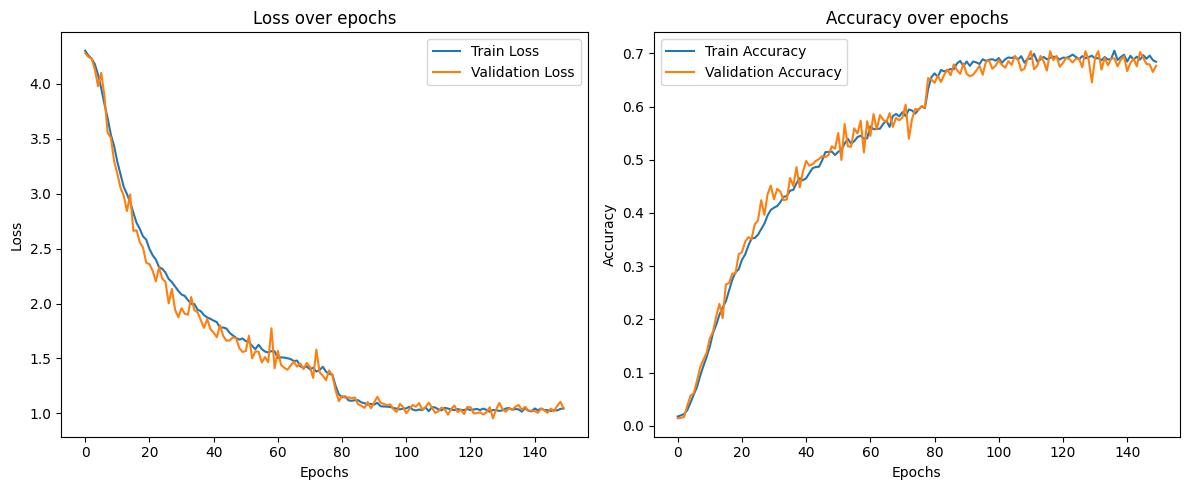

In [22]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

## 3. Evaluate

In [118]:
model = CoAtNet(num_classes=len(dataset.label2idx), in_channels=1)
model.to(device)
model.load_state_dict(torch.load('models/model_all_correct.pth')['model_state_dict'])

<All keys matched successfully>

In [119]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for data, targets, devices in test_loader:
        data, targets, devices = data.to(device), targets.to(device), devices.to(device)
        if len(data.shape) == 3:
            data = data.unsqueeze(1)
        outputs = model(data)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7582


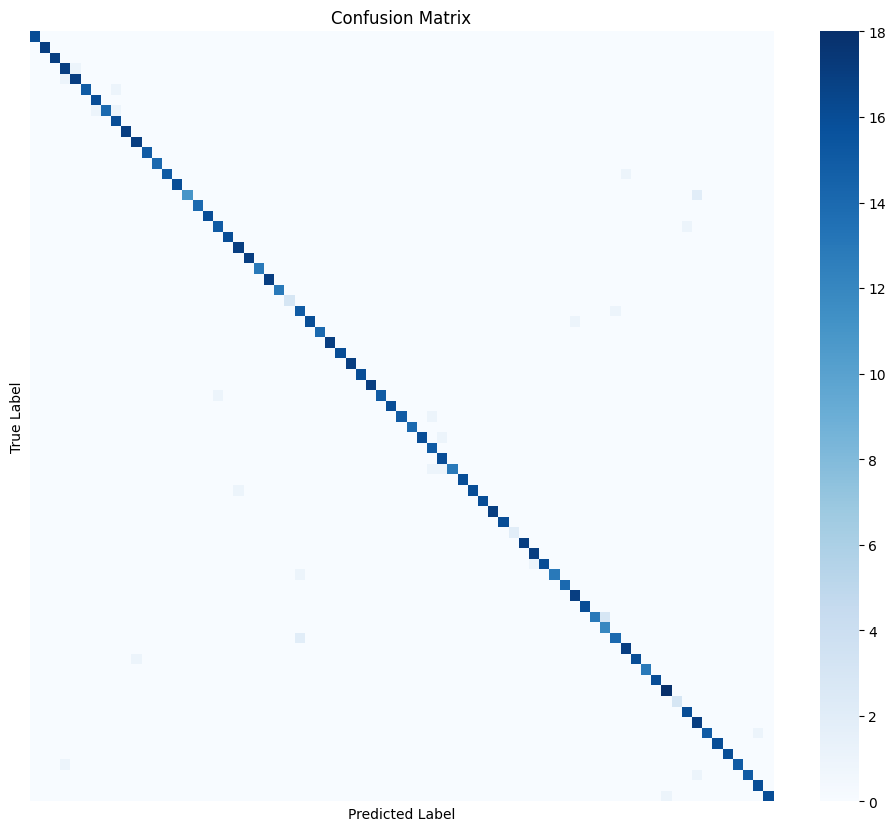

In [112]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Set model to evaluation mode
model.eval()

# Lists to store true labels and predictions
all_targets = []
all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for data, targets, devices in test_loader:
        data, targets, devices = data.to(device), targets.to(device), devices.to(device)

        # Ensure correct input dimensions
        if len(data.shape) == 3:
            data = data.unsqueeze(1)

        # Forward pass
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)

        # Store results
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Get unique class labels
class_labels = np.unique(all_targets)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions, labels=class_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# Remove x and y axis ticks completely
plt.xticks([])
plt.yticks([])
plt.show()

In [121]:
def isolate_keystrokes(audio, sr, segment_length=14400, n_fft=1024, hop_length=256, min_separation=43):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    energy = np.sum(np.abs(stft), axis=0)
    threshold = np.percentile(energy, 95) 
    min_separation = int(0.1 * sr / hop_length) 
    keystroke_frames = np.where(energy > threshold)[0]
    if len(keystroke_frames) == 0:
        return threshold, [], []
    groups = []
    current_group = [keystroke_frames[0]]
    for i in range(1, len(keystroke_frames)):
        if keystroke_frames[i] - keystroke_frames[i - 1] > min_separation:
            groups.append(current_group)
            current_group = []
        current_group.append(keystroke_frames[i])  
    if current_group:
        groups.append(current_group)     
    segments = []
    segment_starts = []
    for group in groups:
        center_frame = int(np.mean(group))
        start = max((center_frame * hop_length) - segment_length // 2, 0)
        end = start + segment_length
        if end > len(audio):
            start = max(0, len(audio) - segment_length)
            end = len(audio)
        segment = audio[start:end]
        if len(segment) == segment_length: 
            segments.append(segment)
            segment_starts.append(start / sr) 
    return threshold, segments, segment_starts

def visualize_keystrokes(audio, sr, segment_starts, title="Detected Keystrokes"):
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(audio, sr=sr)
    for start_time in segment_starts:
        plt.axvline(start_time, color='red', linestyle='--')
    plt.title(title)
    plt.show()
    
idx2label = {v: k for k, v in dataset.label2idx.items()}

SENT_DIR = "data/sentences"
model.eval()
predictions = {}
SR = 44100  
for fname in tqdm(os.listdir(SENT_DIR)):
    sid = fname.split(".")[0]
    wav_path = os.path.join(SENT_DIR, fname)
    print(f"Processing {wav_path}")
    audio, _ = librosa.load(wav_path, sr=SR)
    threshold, segments, segment_starts = isolate_keystrokes(audio, sr=SR)
    pred_chars = []
    with torch.no_grad():
        for seg in segments:
            mel = generate_mel_spectrogram(seg, sr=SR)
            mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-6)
            x = torch.from_numpy(mel).unsqueeze(0).unsqueeze(0).to(device)
            out = model(x)
            probs = torch.nn.functional.softmax(out, dim=1)
            idx = probs.argmax(dim=1).item()
            pred_chars.append(idx2label[idx])
    predictions[sid] = pred_chars

# === Final Output ===
print("\nPredictions:")
texts = {}
for sid, text in predictions.items():
    print(f"{sid}: {predictions[sid]}")
    text = ["." if pred=="fullstop" else " " if pred=="space" else pred if len(pred)==1 else "" for pred in text]
    texts[sid] = "".join(text)
    print(f"Final text: {texts[sid]}")

  0%|          | 0/5 [00:00<?, ?it/s]

Processing data/sentences/5.wav


 20%|██        | 1/5 [00:00<00:01,  2.17it/s]

Processing data/sentences/2.wav


 40%|████      | 2/5 [00:00<00:01,  2.22it/s]

Processing data/sentences/1.wav


 60%|██████    | 3/5 [00:01<00:00,  2.43it/s]

Processing data/sentences/4.wav


 80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

Processing data/sentences/3.wav


100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Predictions:
5: ['m', 'p', 'slash', 'j', 'd', 's', 'space', 'd', 'h', 'a', 'p', 'm', 'd', 'space', 'p', 'p', 'k', 'd', 'space', 'd', 'r', 'a', 'g', 'p', 'n', 's', 'space', 'd', 'slash', '0', 'a', 't', 'e', 'd', 'space', 'm', 'a', 'd', 'i', 'o', 't', 'space', 'a', 'b', 'm', 'o', 'r', 'd', 'space', 't', 'h', 'b', '6', 'a', 'd', 't', 'm', 'n', 'slash', 'o', 'o', 'm', 'space', '9', '0', 'h', 'fullstop']
Final text: mpjds dhapmd ppkd dragpns d0ated madiot abmord thb6adtmnoom 90h.
2: ['a', 'space', 's', 'u', 'd', 'd', 'r', 'rctrl', 'space', 'x', 'u', 's', 't', 'space', 'i', 'rctrl', 'space', 't', 'i', 'n', 'd', 'space', 's', 'c', 'a', 't', 't', 't', 't', 'e', 'd', 'space', 't', 'v', 'r', 'v', 'm', 'a', 'v', 'i', 'c', 'i', 'a', 'n', 'a', 'space', 'c', 'a', 'r', '6', '5', 'space', 'a', 'c', 'r', 'i', 's', 's', 'v', 't', 'h', 'e', 'space', 'r', 'o', 'o', 'f', 't', 'i', 'p', 'fullstop']
Final text: a suddr xust i tind scatttted tvrvmaviciana car65 acrissvthe rooftip.
1: ['t', 'h', 'd', '6', 'o'

## 4. Language Model

In [84]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import accelerate
import torch
import torch.nn.functional as F

/home/dayita/MLSP/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [85]:
with open('config.json', 'r') as f:
    config = json.load(f)

model_id = config['MODELS']['llama3-8B']

In [99]:
PROMPT = '''You are a helpful assistant that corrects typos in sentences based on the likely intent of the user. Each typo was generated by a model that tries to guess typed words based on keystroke sounds. 

The correction should be the closest valid sentence with proper spelling and grammar, assuming the model made as few mistakes as possible.

Examples are given below.

Typo: "the wuick bronw fix"
Correct: "the quick brown fox"

Typo: "how arw ypu"
Correct: "how are you"

Typo: "in tghe beeginning"
Correct: "in the beginning"

Correct each of the following typo sentences. Give the corrected sentence only, without any additional text or explanation.
'''

In [101]:
from transformers import pipeline

# Combine all messages into a single prompt string
prompt = PROMPT
for sentence in list(texts.values()):
    prompt += f'\nTypo: "{sentence}"\n'
    
print(prompt)

# Now generate using the text-generation pipeline
generator = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

outputs = generator(prompt, max_new_tokens=256)
generated_text = outputs[0]['generated_text']

# Print the full output
print(generated_text)

You are a helpful assistant that corrects typos in sentences based on the likely intent of the user. Each typo was generated by a model that tries to guess typed words based on keystroke sounds. 

The correction should be the closest valid sentence with proper spelling and grammar, assuming the model made as few mistakes as possible.

Examples are given below.

Typo: "the wuick bronw fix"
Correct: "the quick brown fox"

Typo: "how arw ypu"
Correct: "how are you"

Typo: "in tghe beeginning"
Correct: "in the beginning"

Correct each of the following typo sentences. Give the corrected sentence only, without any additional text or explanation.

Typo: "xki  x dvabex dikelaltfiaxfnnd xkkq eg dqzi i qcivxv  ge vf ezviiv zkzk"

Typo: "p si drm rctrl st if wib  sv ttrr   trctrlr marctrlici b  var   acr ss trctrle r  f o fullstop"

Typo: "tbe ordnge cat stared suanidioualyuat tje dabding tnasterfullstop"

Typo: "beneatjvtbe gibrarys bdsementctjeyufound a dkouvbabeledvdo nouuooebfullstop"

Typo: 

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


You are a helpful assistant that corrects typos in sentences based on the likely intent of the user. Each typo was generated by a model that tries to guess typed words based on keystroke sounds. 

The correction should be the closest valid sentence with proper spelling and grammar, assuming the model made as few mistakes as possible.

Examples are given below.

Typo: "the wuick bronw fix"
Correct: "the quick brown fox"

Typo: "how arw ypu"
Correct: "how are you"

Typo: "in tghe beeginning"
Correct: "in the beginning"

Correct each of the following typo sentences. Give the corrected sentence only, without any additional text or explanation.

Typo: "xki  x dvabex dikelaltfiaxfnnd xkkq eg dqzi i qcivxv  ge vf ezviiv zkzk"

Typo: "p si drm rctrl st if wib  sv ttrr   trctrlr marctrlici b  var   acr ss trctrle r  f o fullstop"

Typo: "tbe ordnge cat stared suanidioualyuat tje dabding tnasterfullstop"

Typo: "beneatjvtbe gibrarys bdsementctjeyufound a dkouvbabeledvdo nouuooebfullstop"

Typo: 